In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from network.examples import community, virus
from network.simulation import rv

import random

import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

In [7]:
def generate_sim(n_communities, community_size, orphans):
    total_ppl = n_communities * community_size + orphans
    # assume 3 strong connections per person
    n_strong_conns = total_ppl * 3
    # assume 6 weak connections per person
    n_weak_conns = total_ppl * 6
    
    core_kw = dict(strength=0.8)

    def strong_kw_func(strength):
        def func():
            days_together = random.randint(1, 5)
            p_together = days_together / 7
            return dict(strength=p_together * strength)

        return func

    strong_kw = strong_kw_func(strength=0.8)
    weak_kw = dict(strength=0.1)
    
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw=core_kw, strong_kw=strong_kw, weak_kw=weak_kw
    )
    
    def reset_weak_edges(graph, strength):
        edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
        for prev_weak_edge in edges_to_remove:
            graph.remove_edge(prev_weak_edge.nodes)

        # generate edges will generate both outbound and inbound edges so we only need to /2
        n_new_weak_edges = int(len(edges_to_remove) / 2)
        for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
            graph.add_edge(new_weak_edge, kind='weak', strength=strength)

    def simple_virus_runner(transmission):
        for step in transmission:
            yield step
            reset_weak_edges(graph, weak_kw['strength'])
    
    sim = virus.virus_simulation(
        graph=graph,
        patient0=0,
        incubation_period=rv.randint(2, 14),
        contagious_for=rv.choice(0, 1, 7),
        runner=simple_virus_runner
    )
    
    return sim

In [8]:
sim1 = generate_sim(n_communities=250, community_size=3, orphans=250)
sim2 = generate_sim(n_communities=750, community_size=3, orphans=750)
sim3 = generate_sim(n_communities=1250, community_size=3, orphans=1250)

In [9]:
sim1.path()
sim2.path()
sim3.path()

<generator object Simulation.path.<locals>.<genexpr> at 0x11f950408>

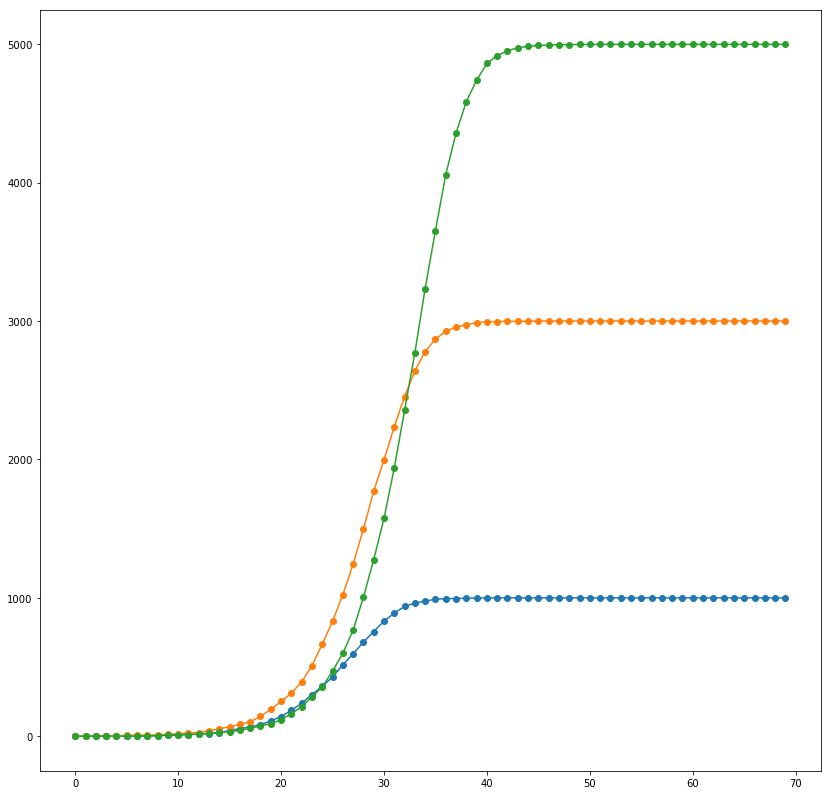

In [12]:
def sim_sequence(sim, n):
    for i in range(n):
        yield sim.history[i]['broadcasts']

plt.figure(figsize=(14, 14))
for sim in (sim1, sim2, sim3):
    plt.plot(range(70), list(sim_sequence(sim, 70)), 'o-')
# plt.plot(range(70), list(sim_sequence(70)), 'bo-')